In [3]:
# This code is inspired by this kernel: https://www.kaggle.com/tapioca/lightgbm-score-booster
# another kernel to read: https://www.kaggle.com/jadrayes/join-market-and-news-ii
import numpy as np
import pandas as pd
import time
import lightgbm as lgb
import matplotlib.pyplot as plt
import math
import seaborn as sns
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

In [4]:
# Removing outliers (defined as data m times std. away from its mean)
def remove_outliers(data, columns, m=3):
    """
    type data: DataFrame
    type columns: list[str]
    type m: int
    rtype: DataFrame
    """
    normal = np.asarray([True] * len(data))
    for i in range(len(columns)):
        normal = normal & (abs(data[columns[i]] - np.mean(data[columns[i]])) <= m * np.std(data[columns[i]]))
    return data[normal]

In [5]:
# Computing daily score from prediction
def daily_score(predtemplatedf): 
    """
    type predtemplatedf: DataFrame (shape: number of assetCode's in one day * 5)
    rtype: float
    """
    return (predtemplatedf.universe * predtemplatedf.returnsOpenNextMktres10 * predtemplatedf.confidenceValue).sum()

In [6]:
# Computing final submission score
def final_score(score):
    """
    type score: DataFrame (shape: number of unique days in the test set * 2)
    rtype: float
    """
    return np.mean(score.daily_score) / np.std(score.daily_score)

In [7]:
# For returns prediction at each date, rescale it to mean return of zero and std of 0.125. (why?)
def post_scaling(pred_Y):
    """
    type pred_Y: array
    rtype: array
    """
    mean, std = np.mean(pred_Y), np.std(pred_Y)
    pred_Y = (pred_Y - mean) / std / 8
    return np.clip(pred_Y, -1, 1)

In [42]:
# Importing the merged dataset
print('Importing the merged dataset... This may take a minute.')
merged_data = pd.read_csv("./merged_data_assetCodes.csv") # number of rows have news merged: 1147200/4072956
# dropping data of the financial crisis period (ended on June 2009 according to NBER)
merged_data = merged_data[merged_data['time']>='2009-07-01'] # 3140398/4072956 remain
print('Done!')

Importing the merged dataset... This may take a minute.


In [828]:
# how many NaN's need to be cleaned
# Q: why summing previous 10 returns doesn't equal to Prev10?
#merged_data.count()
# 1. in market data, only PrevMktres have NaN's
# on 2001-01-01, PrevMktres1 are all NaN (1418)
# from 2007-01-01 to 02-14, PrevMktres10 are all NaN (14290)
# since 2007-02-15, PrevMktres1 have 0.4% NaN while PrevMktres10 have 2%
# 2. in news data, if merged, all features have valid values. NaN means not merged (72%)
# 3. more than half news have novelty of 0!
# 4. significant portion of news have volumeCount of 0 (all days >10%)
# 5. adding a new feature: noNews after filling NaN

In [43]:
# Handling missing values
# tutorial: https://towardsdatascience.com/handling-missing-values-in-machine-learning-part-1-dda69d4f88ca
print('Handling missing values...')
# Market data: replacing NaN by implied market-adjusted returns
Raw_cols = ['returnsClosePrevRaw1', 'returnsOpenPrevRaw1', 'returnsClosePrevRaw10', 'returnsOpenPrevRaw10']
Mktres_cols = ['returnsClosePrevMktres1', 'returnsOpenPrevMktres1', 'returnsClosePrevMktres10', 'returnsOpenPrevMktres10']
Mkt_cols = ['returnClosePrevMkt1', 'returnOpenPrevMkt1', 'returnClosePrevMkt10', 'returnOpenPrevMkt10']
for i in range(len(Mkt_cols)):
    merged_data[Mkt_cols[i]] = merged_data[Raw_cols[i]] - merged_data[Mktres_cols[i]]
    merged_data[Mkt_cols[i]] = merged_data.groupby('time')[Mkt_cols[i]].transform(lambda x: x.mean())
    merged_data[Mktres_cols[i]] = merged_data[Mktres_cols[i]].fillna(merged_data[Raw_cols[i]] - merged_data[Mkt_cols[i]])
# News data: adding a 'nonews' feature & then, replacing NaN by a fixed constant
merged_data['noNews'] = merged_data.sentimentPositive.isnull().astype(int)
merged_data.fillna(-999, inplace=True)
assert merged_data.isnull().sum().sum() == 0
print('Done!')

#nancols = [col for col in merged_data.columns if col not in ['time', 'assetCode', 'assetName', 'universe']]
#for i in range(len(nancols)):
    # first, fill in nan by feature mean of each assetCode
#    merged_data[nancols[i]] = merged_data.groupby('assetCode')[nancols[i]].transform(lambda x: x.fillna(x.mean()))
    # if nan still exists, fill in nan by feature mean of all assetCode's
#    merged_data[nancols[i]] = merged_data[nancols[i]].transform(lambda x: x.fillna(x.mean()))

Handling missing values...
Done!


In [44]:
# Handling outliers
# tutorial: https://machinelearningmastery.com/how-to-identify-outliers-in-your-data/
print('Removing outliers...')
outliercols = ['volume', 'close', 'open'] + Raw_cols + Mktres_cols
before_removal = len(merged_data)
merged_data = remove_outliers(merged_data, outliercols, m=3)
print(str(before_removal - len(merged_data)) + ' rows of sample are removed as outliers.')
print('Done!')

Removing outliers...
128191 rows of sample are removed as outliers.
Done!


In [460]:
# Getting some insights for feature engineering from correlation analysis
#corrcols = [col for col in merged_data.columns if col not in ['time', 'assetCode', 'assetName', 'universe', 'returnsOpenNextMktres10']]
#print('pearson correlation and its p value between returnsOpenNextMktres10 and each feature:')
#print('-------------------------------------------------------------------------------------')
#for i in range(len(corrcols)):
#    print('with ' + corrcols[i] + ': ' + str(pearsonr(merged_data[corrcols[i]], merged_data.returnsOpenNextMktres10)))

## a few remarks:
# 1. 'open' price and returns are much more relevant than 'close'
# 2. 'daytrend' is an important feature

In [45]:
# Feature engineering
print('Creating some new features...')
# market features:
merged_data['daytrend'] = merged_data['close'] / merged_data['open']
#merged_data['average'] = (merged_data['close'] + merged_data['open']) / 2
#merged_data['moving_average_10_days'] = merged_data.groupby('assetCode')['open'].transform(lambda x: pd.Series.ewm(x, span=10).mean())
#merged_data['moving_average_20_days'] = merged_data.groupby('assetCode')['open'].transform(lambda x: pd.Series.ewm(x, span=20).mean())
#merged_data['moving_average_50_days'] = merged_data.groupby('assetCode')['open'].transform(lambda x: pd.Series.ewm(x, span=50).mean())
#merged_data['moving_average_100_days'] = merged_data.groupby('assetCode')['open'].transform(lambda x: pd.Series.ewm(x, span=100).mean())
#merged_data['moving_average_200_days'] = merged_data.groupby('assetCode')['open'].transform(lambda x: pd.Series.ewm(x, span=200).mean())
merged_data['returnsOpenPrevMktres10_lag_1'] = merged_data.groupby('assetCode')['returnsOpenPrevMktres10'].transform(lambda x: x.shift(10).fillna(x.mean()))
merged_data['returnsOpenPrevRaw10_lag_1'] = merged_data.groupby('assetCode')['returnsOpenPrevRaw10'].transform(lambda x: x.shift(10).fillna(x.mean()))
merged_data['returnsOpenPrevMktres10_lag_2'] = merged_data.groupby('assetCode')['returnsOpenPrevMktres10'].transform(lambda x: x.shift(20).fillna(x.mean()))
merged_data['returnsOpenPrevRaw10_lag_2'] = merged_data.groupby('assetCode')['returnsOpenPrevRaw10'].transform(lambda x: x.shift(20).fillna(x.mean()))
merged_data['returnsOpenPrevMktres10_lag_3'] = merged_data.groupby('assetCode')['returnsOpenPrevMktres10'].transform(lambda x: x.shift(30).fillna(x.mean()))
merged_data['returnsOpenPrevRaw10_lag_3'] = merged_data.groupby('assetCode')['returnsOpenPrevRaw10'].transform(lambda x: x.shift(30).fillna(x.mean()))
merged_data['returnsOpenPrevMktres10_lag_4'] = merged_data.groupby('assetCode')['returnsOpenPrevMktres10'].transform(lambda x: x.shift(40).fillna(x.mean()))
merged_data['returnsOpenPrevRaw10_lag_4'] = merged_data.groupby('assetCode')['returnsOpenPrevRaw10'].transform(lambda x: x.shift(40).fillna(x.mean()))
merged_data['returnsClosePrevMktres10_lag_1'] = merged_data.groupby('assetCode')['returnsClosePrevMktres10'].transform(lambda x: x.shift(10).fillna(x.mean()))
merged_data['returnsClosePrevRaw10_lag_1'] = merged_data.groupby('assetCode')['returnsClosePrevRaw10'].transform(lambda x: x.shift(10).fillna(x.mean()))
merged_data['returnsClosePrevMktres10_lag_2'] = merged_data.groupby('assetCode')['returnsClosePrevMktres10'].transform(lambda x: x.shift(20).fillna(x.mean()))
merged_data['returnsClosePrevRaw10_lag_2'] = merged_data.groupby('assetCode')['returnsClosePrevRaw10'].transform(lambda x: x.shift(20).fillna(x.mean()))
merged_data['returnsClosePrevMktres10_lag_3'] = merged_data.groupby('assetCode')['returnsClosePrevMktres10'].transform(lambda x: x.shift(30).fillna(x.mean()))
merged_data['returnsClosePrevRaw10_lag_3'] = merged_data.groupby('assetCode')['returnsClosePrevRaw10'].transform(lambda x: x.shift(30).fillna(x.mean()))
merged_data['returnsClosePrevMktres10_lag_4'] = merged_data.groupby('assetCode')['returnsClosePrevMktres10'].transform(lambda x: x.shift(40).fillna(x.mean()))
merged_data['returnsClosePrevRaw10_lag_4'] = merged_data.groupby('assetCode')['returnsClosePrevRaw10'].transform(lambda x: x.shift(40).fillna(x.mean()))

# ... more to be added
# news features:
# merged_data['pricevolume'] = merged_data['volume'] * merged_data['close']

print('Done!')

Creating some new features...
Done!


In [46]:
mdf = merged_data

In [47]:
# Defining training and target features
targetcol = 'target'
mdf[targetcol] = (mdf['returnsOpenNextMktres10'] > 0).astype(int) # we be classifying binary variable
# dropfeatures =  ['close', 'returnsClosePrevRaw1', 'returnsClosePrevMktres1', 'returnsClosePrevRaw10', 'returnsClosePrevMktres10']
dropfeatures = []
traincols = [col for col in mdf.columns if col not in ['time', 'assetCode', 'assetName', 'universe', 'returnsOpenNextMktres10'] + [targetcol] + dropfeatures]

In [54]:
# Splitting the dataset into training, validation and test sets
print('Building training/validation/test sets...')
print('-------------------------')
dates = mdf['time'].unique()
print('The data spans ' + str(len(dates)) + ' days.')
print('We assign data of the first 65% dates as the training set,...')
print('the next 15% dates as the validation set,...')
print('and the last 20% dates as the test set.')
train = range(len(dates))[:int(0.65*len(dates))]
val = range(len(dates))[int(0.65*len(dates)):int(0.80*len(dates))]
test = range(len(dates))[int(0.80*len(dates)):]

# train data
X_train = mdf[traincols].loc[mdf['time'].isin(dates[train])].values
Y_train = mdf[targetcol].loc[mdf['time'].isin(dates[train])].values
# validation data
X_val = mdf[traincols].loc[mdf['time'].isin(dates[val])].values
Y_val = mdf[targetcol].loc[mdf['time'].isin(dates[val])].values
# test data
X_test = mdf[['time'] + traincols].loc[mdf['time'].isin(dates[test])] # need to extract by time when predict
Y_test = mdf[['time', targetcol]].loc[mdf['time'].isin(dates[test])]

print('-------------------------')
print("We'll train " + str(len(X_train) + len(X_val)) + ' samples with ' + str(np.size(X_train, 1)) + ' features')

Building training/validation/test sets...
-------------------------
The data spans 1890 days.
We assign data of the first 65% dates as the training set,...
the next 15% dates as the validation set,...
and the last 20% dates as the test set.
-------------------------
We'll train 2371465 samples with 48 features


In [55]:
# Feature scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test[traincols] = sc.transform(X_test[traincols].values)

In [82]:
#######################################
##
## LightGBM: training
## online tutorials:
## doc: https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html
## blog: https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc
##
#######################################
print('Training LightGBM...')
print('--------------------')

t = [80, -1, 0.003]

params = {'objective': 'binary',
          'metric': 'binary_logloss',
          'num_leaves': t[0], # larger for better accuracy
          'max_depth': t[1], # larger for better accuracy. No limit: <0
          # 'min_data_in_leaf': t[2], # hundreds to thousands: larger to prevent over-fitting
          # 'max_bin': t[3],
          'learning_rate': t[2], # smaller for better accuracy
          'bagging_fraction': 0.9, # subsample
          'feature_fraction': 0.9, # colsample_bytree
          'bagging_freq': 5,       # subsample_freq
          'bagging_seed': 2018,
          'verbosity': -1}

lgtrain, lgval = lgb.Dataset(X_train, Y_train), lgb.Dataset(X_val, Y_val)

train_start = time.time()
lgbmodel = lgb.train(params, lgtrain, 2000, valid_sets=[lgtrain, lgval], early_stopping_rounds=100, verbose_eval=200)
print('--------------------')
print('Training is done!')
print("Training LightGBM took %.0f minutes." % math.ceil((time.time() - train_start)/60))

Training LightGBM...
--------------------
Training until validation scores don't improve for 100 rounds.
[200]	training's binary_logloss: 0.684277
[400]	training's binary_logloss: 0.679456
[600]	training's binary_logloss: 0.67589
[800]	training's binary_logloss: 0.672753
[1000]	training's binary_logloss: 0.670036
[1200]	training's binary_logloss: 0.667631
[1400]	training's binary_logloss: 0.665512
[1600]	training's binary_logloss: 0.663637
[1800]	training's binary_logloss: 0.661977
[2000]	training's binary_logloss: 0.660523
Did not meet early stopping. Best iteration is:
[2000]	training's binary_logloss: 0.660523
--------------------
Training is done!
Training LightGBM took 14 minutes.


In [83]:
#######################################
##
## LightGBM: prediction
##
#######################################
print('Generating predictions...')
print('-------------------------')
print(str(len(X_test)) + ' samples to be predicted... This may take several minutes')
Predtemplatedf = mdf[['time', 'assetCode', 'universe', 'returnsOpenNextMktres10']].loc[mdf['time'].isin(dates[test])]
score = pd.DataFrame({'time': dates[test], 'daily_score': np.zeros(len(test))})
# in submission version, can drop rows that universe==0 from the test set

Y_pred = np.array([])

pred_start = time.time()
for predday in dates[test]:
    x_test = X_test[traincols].loc[X_test['time'] == predday].values
    y_pred = lgbmodel.predict(x_test, num_iteration=lgbmodel.best_iteration) * 2 - 1 # transform [0,1] to [-1,1]
    Y_pred = np.append(Y_pred, y_pred)
    #y_test = Y_test[targetcol].loc[Y_test['time'] == predday].values
    #accuracy.append(np.sign(y_pred) == np.sign(y_test))
    predtemplatedf = Predtemplatedf[Predtemplatedf['time'] == predday]
    predtemplatedf = predtemplatedf.assign(confidenceValue = post_scaling(y_pred))
    score.loc[score['time'] == predday, 'daily_score'] = daily_score(predtemplatedf)
print('prediction is done!')
print('prediction took %.0f minutes.' % math.ceil((time.time() - pred_start)/60))
print('-------------------------')
Y_testsign = Y_test[targetcol].values *2 - 1
assert len(Y_testsign) == len(Y_pred)
accuracy = (Y_testsign == np.sign(Y_pred))
accurate = sum(accuracy) / len(Y_test)
print('accuracy of correct sign prediction is: ', accurate)
submission_score = final_score(score)
print('our submission score is: ', submission_score)

Generating predictions...
-------------------------
640742 samples to be predicted... This may take several minutes
prediction is done!
prediction took 7 minutes.
-------------------------
accuracy of correct sign prediction is:  0.5418577212044785
our submission score is:  0.530313835496109


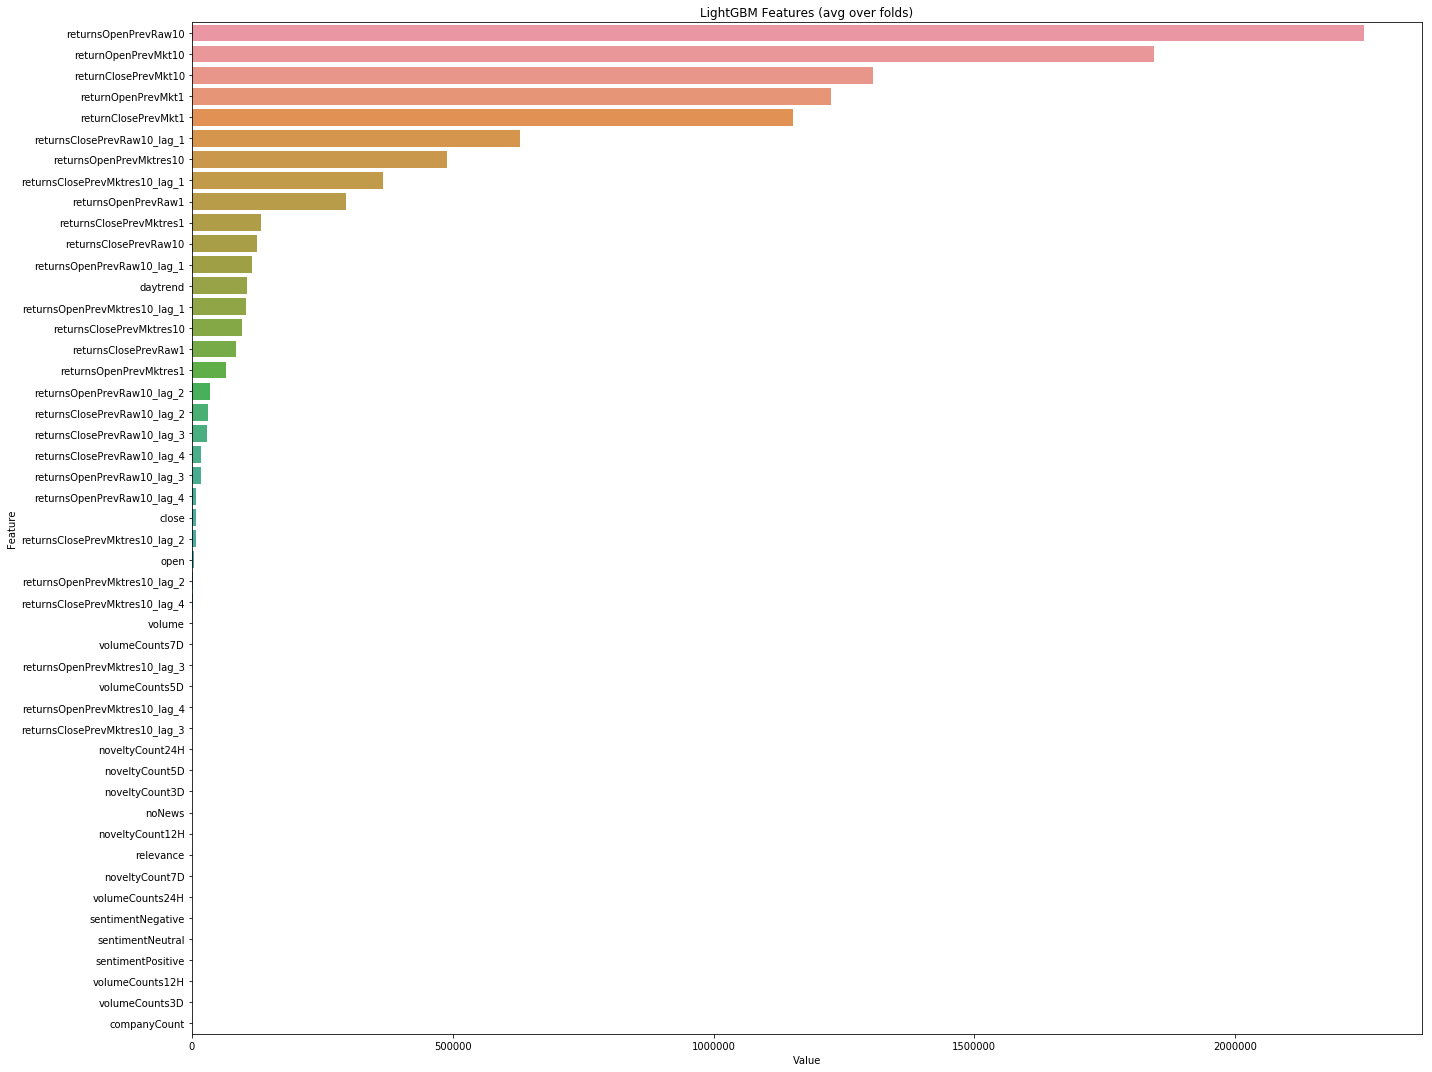

<Figure size 432x288 with 0 Axes>

In [59]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns
feature_imp = pd.DataFrame(sorted(zip(lgbmodel.feature_importance(importance_type='gain'), traincols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 15))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

In [283]:
## record of results:
# train merged_success, test merged_success: 0.50
# train merged_data, test merged_success: 0.4964
## Remark: it seems that training entire merged_data makes no improvement compared to training merged_success which saves time
## But, we should test all merged_data not only merged_success!
# train merged_data, test merged_data: 0.4827
# train merged_success, test merged_data: 0.4844 (I'll use this as benchmark to save time for future test)
## feature engineering ...
# adding bartrend: 0.4857
# adding [bartrend, average, pricevolume]: 0.4790
## using new merged_data_assetCodes (115w rows successfully merged compared to 111w of previous version)
# merged_data_assetCodes: 0.4888
## adding post_scaling: 0.5133 # why rescaling improves prediction performance?
## fill in nan & adding laged market features & dropping 'close' features: 0.5088 (max_depth=-1)
# set max_depth to 7 to prevent over-fitting: 0.5076
# training:
# adding back close features, t = [100, -1, nan, nan, 0.01], v_loss = 0.686266, score = 0.5027
# t = [100, -1, nan, nan, 0.003], v_loss = 0.686256, score = 0.5030
# t = [80, -1, 0.01], new method filling in NaN, removing outliers, adding new features: v_loss = 0.686113, score = 0.5170
# t = [80, -1, 0.003], adding more lag returns, dropping moving average: v_loss = 0.685673, score = 0.5108
# corrected the lag features of ReturnsPrev10: v_loss = 0.686173, score = 0.5497 !

In [ ]:
## to-do:
# feature scaling [done!]
# pre-process NaN [done!]
# adding lag features to account for the time series dependence? [done!]
# feature importance? [done!]
# excluding outliers of 0.5 < daytrend < 1.5 [think more]
# how to train lgbm and check diagnostics? [Fang will do]
# use cross-validation to avoid over-fitting [Fang will do]
# does including news improve prediction performance? [wait new data]
# can we use two seperate models to predict those assetCode's with and without news data? (only about 1/4 have news) [add a feature 'noNews']
# classifying more than two categories? [try!]
